# **연세-네이버클라우드 데이터사이언스 교육과정**
## 텍스트마이닝: 문서 분류(Text Classification)

박기영 (연세대 경제학부)

06NLP_Classification.ipynb의 목차

네이버 영화평을 긍정과 부정으로 분류하는 기법 학습
1. 네이버 영화평 불러오기
2. 전처리
3. LSTM



In [ ]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import os
import pandas_datareader as pdr
from datetime import date

# for preferred display
%config InlineBackend.figure_format = 'retina'   # for retina display in Mac
np.set_printoptions(precision=3, suppress=True)  # for pretty display of numpy arrays
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 10

time: 13.9 ms (started: 2021-02-14 07:40:27 +00:00)


In [ ]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('font', size=16)
plt.rc('legend', fontsize=16) 

# for Korean fonts 
plt.rcParams['axes.unicode_minus'] = False

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(14,8)})

time: 31.9 ms (started: 2021-02-14 07:40:27 +00:00)


In [ ]:
# 한글이 들어간 그림을 그리기 위해서 필요함
# 이 셀을 실행시킨 뒤 위 메뉴에서 Runtime -> Restart Runtime 을 한 뒤 처음부터 다시 시작해야 함

!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

from plotnine import *
import plotnine

# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')



time: 2.61 s (started: 2021-02-14 07:40:27 +00:00)


In [ ]:
# 각 셀마다 소요 시간 측정
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.77 s (started: 2021-02-14 07:40:30 +00:00)


## 네이버 영화평 분류

- Naver sentiment movie corpus v1.0: https://github.com/e9t/nsmc/
- 총 20만개 평: 
  - ratings.txt: 20만개 평
  - ratings_train.txt: train group (15만개)
  - ratings_test.txt: test group (5만개)

- 특징: 
  - 모든 평은 140자 미만
  - 긍정, 부정 감성(sentiment)의 수는 동일함 $\rightarrow$ 긍정과 부정 중 하나를 '찍으면' 맞힐 확률은 50%
    - 10만개의 부정 평가 (평점 1-4)
    - 10만개의 긍정 평가 (평정 9-10)
    - '중립' 평가(평점 5-8)는 제외 


In [ ]:
import re
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

time: 1.62 ms (started: 2021-02-14 07:40:33 +00:00)


In [ ]:
# colab에서 konlpy 설치
# colab에서 konlpy 설치할 때 아래 두 줄이 없으면 에러날 수 있음
#!apt-get update
#!apt-get install g++ openjdk-8-jdk 
##timeit
#!pip install jpype1==0.7.0

!pip3 install konlpy
from konlpy.tag import Okt

time: 2.86 s (started: 2021-02-14 07:40:33 +00:00)


### 데이터 불러오기 및 정제

In [ ]:
# 파일 불러오기

url = "https://raw.githubusercontent.com/e9t/nsmc/master/"
filename1 = "ratings_train.txt"
filename2 = "ratings_test.txt"

urllib.request.urlretrieve(url+filename1, filename=filename1)
urllib.request.urlretrieve(url+filename2, filename=filename2)

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

print("train data 리뷰 개수:", len(train_data))
print("test data 리뷰 개수:", len(test_data))

train data 리뷰 개수: 150000
test data 리뷰 개수: 50000
time: 1.34 s (started: 2021-02-14 07:40:36 +00:00)


In [ ]:
# id 컬럼은 불필요
# label: 0 = 부정, 1 = 긍정
train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


time: 587 ms (started: 2021-02-14 07:40:37 +00:00)


In [ ]:
# 중복 관찰치 확인 및 제거
# 150,000개의 리뷰가 있는데 그 중 unique한 것이 146,182개 -> 3,818개의 중복 리뷰가 존재
print(train_data.document.nunique())
print(train_data.label.nunique())

146182
2
time: 110 ms (started: 2021-02-14 07:40:38 +00:00)


In [ ]:
# 중복되는 리뷰 제거
train_data.drop_duplicates(subset='document',inplace=True)

# id 열 제거
train_data.drop(['id'],axis=1,inplace=True)

print('영화 리뷰 수:',len(train_data))

영화 리뷰 수: 146183
time: 114 ms (started: 2021-02-14 07:40:38 +00:00)


In [ ]:
# 0 = 부정, 1 = 긍정의 갯수가 비슷함
train_data.groupby(['label']).count()

,document
label,
0,73342
1,72840


time: 44.1 ms (started: 2021-02-14 07:40:38 +00:00)


In [ ]:
# missing (NaN) 데이터 확인
print(train_data.isnull().sum())

# 몇번째 인덱스에 있는 확인
print(train_data.loc[train_data.document.isnull()])

document    1
label       0
dtype: int64
      document  label
25857      NaN      1
time: 54.3 ms (started: 2021-02-14 07:40:38 +00:00)


In [ ]:
# NaN 값 존재하는 행 제거
train_data = train_data.dropna(how = 'any') 

# missing (NaN) 데이터 확인
print(train_data.isnull().sum())

document    0
label       0
dtype: int64
time: 63.9 ms (started: 2021-02-14 07:40:38 +00:00)


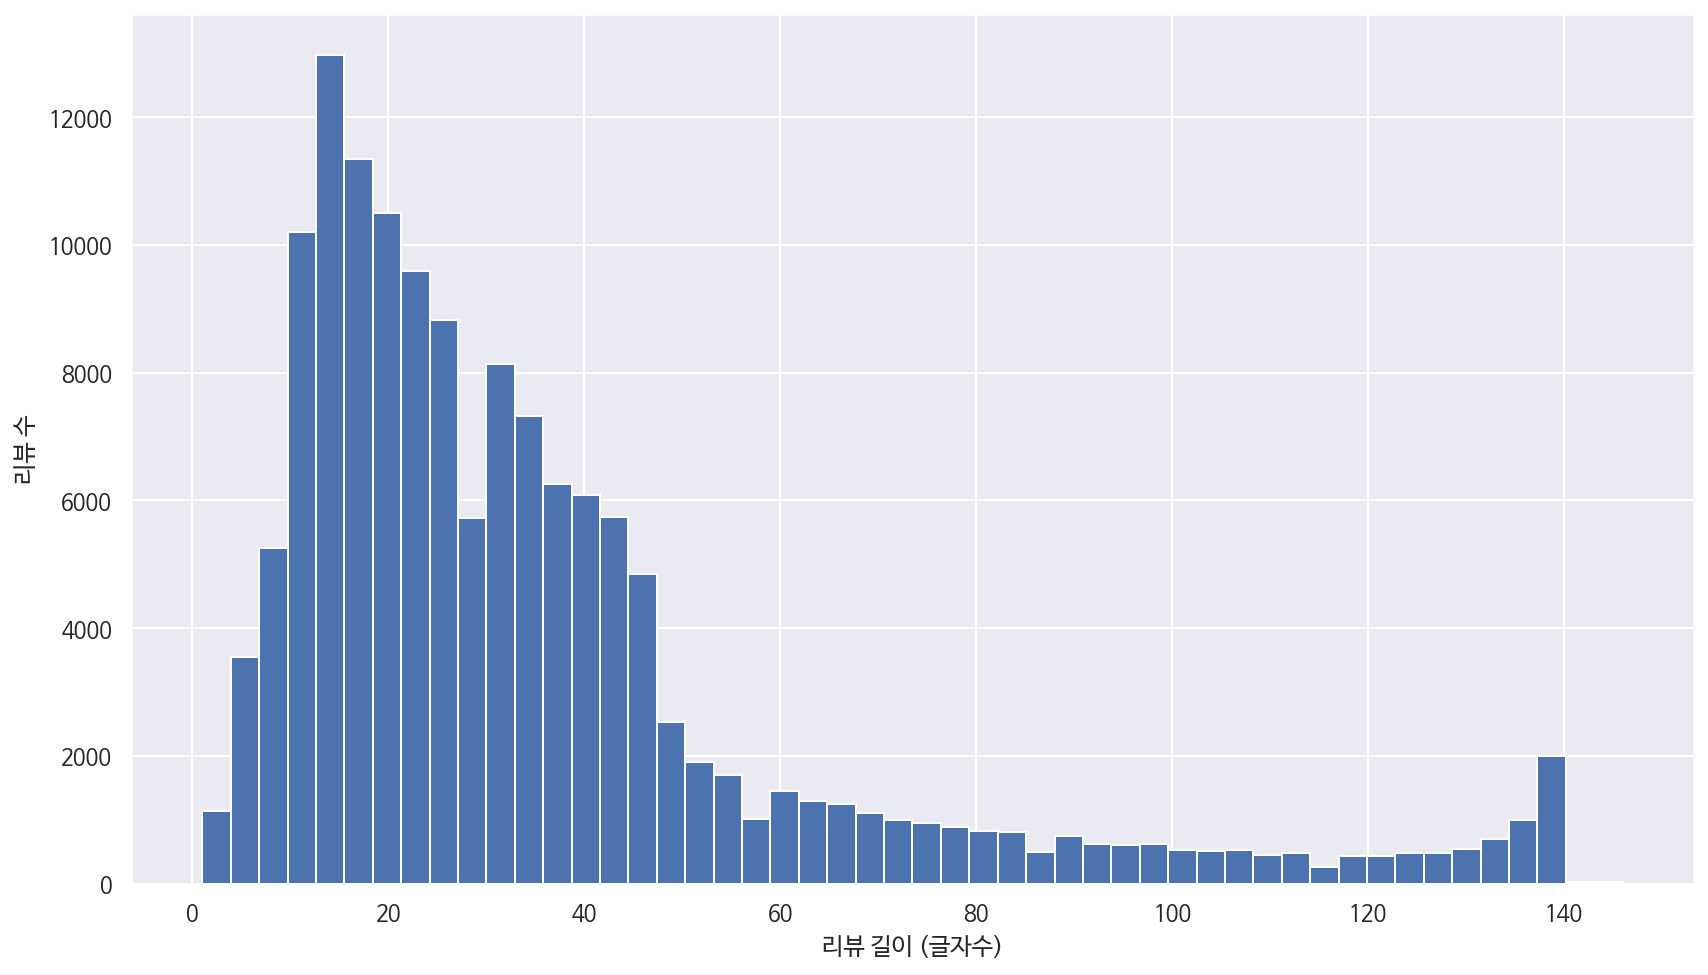

count   146,182.000
mean         35.981
std          29.491
min           1.000
25%          16.000
50%          27.000
75%          43.000
max         146.000
Name: document, dtype: float64
time: 1.67 s (started: 2021-02-14 07:40:38 +00:00)


In [ ]:
# 리뷰 길이 분포 확인
# 다수의 리뷰가 40자를 넘지 않으며, 140자에서 truncated된 것을 볼 수 있음
train_length = train_data.document.astype(str).apply(len)

plt.hist(train_length, bins=50)
plt.xlabel('리뷰 길이 (글자수)')
plt.ylabel('리뷰 수')

plt.show()

print(train_length.describe())

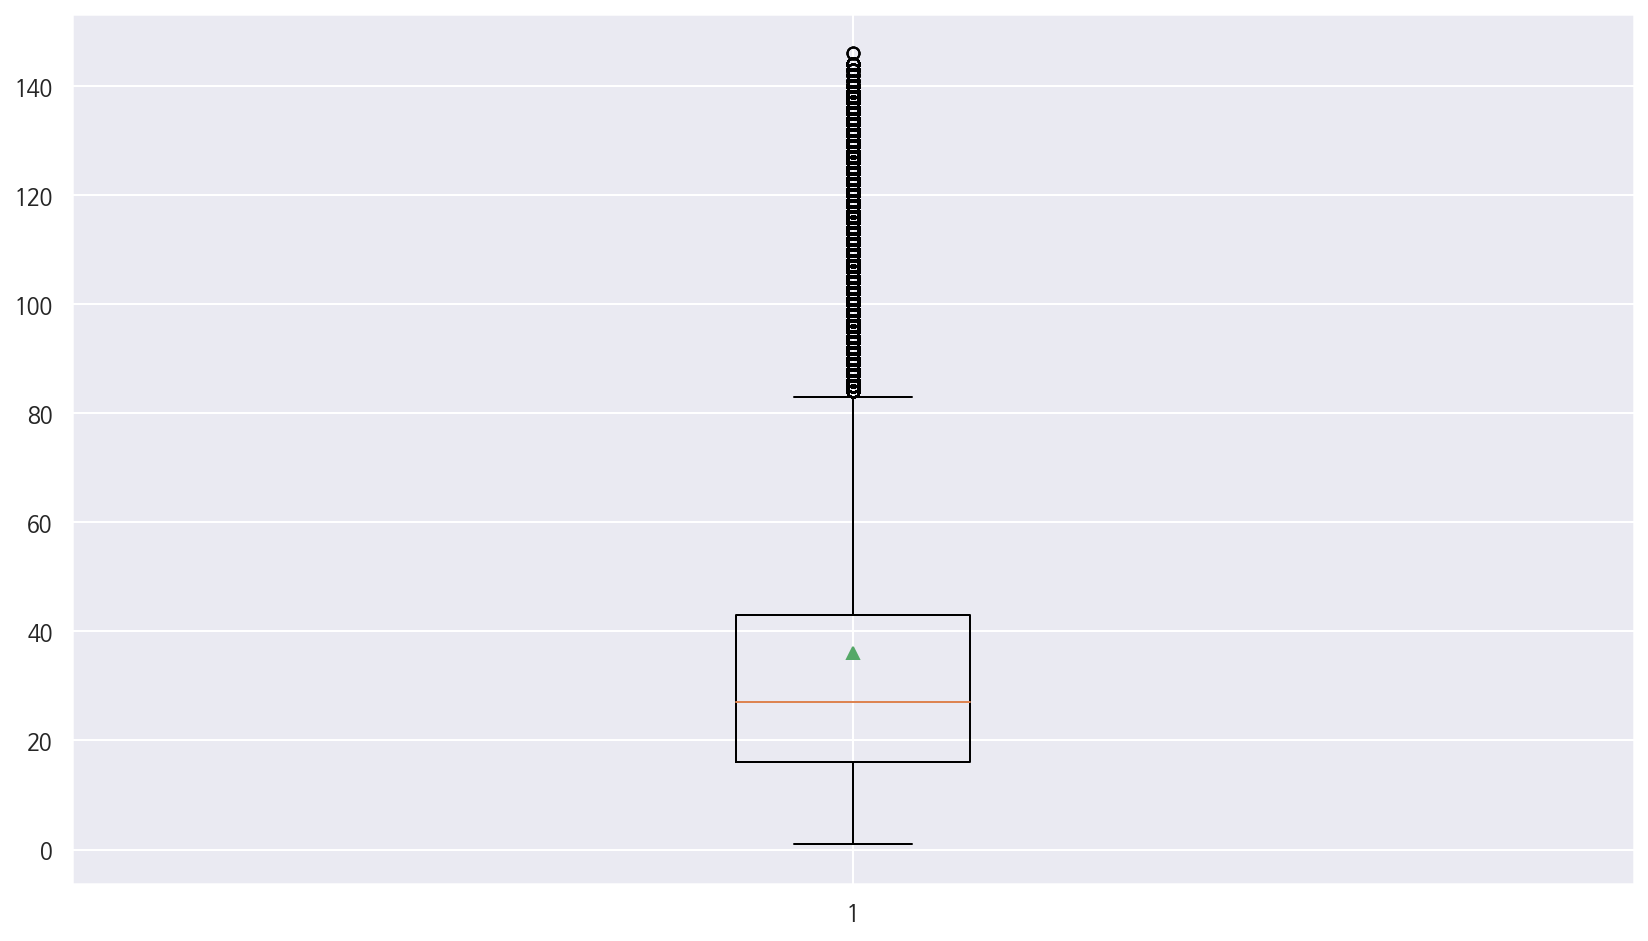

time: 988 ms (started: 2021-02-14 07:40:40 +00:00)


In [ ]:
plt.boxplot(train_length, showmeans=True)
plt.show()

### 전처리

#### 정규표현식 적용

In [ ]:
# 한글, 공백을 제외하고 모두 제거
reg_ex = "[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"
#reg_ex = "[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]"
train_data['document'] = train_data['document'].str.replace(reg_ex,"")
train_data.head(10)

,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0
6,원작의 긴장감을 제대로 살려내지못했다,0
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,액션이 없는데도 재미 있는 몇안되는 영화,1
9,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


time: 306 ms (started: 2021-02-14 07:40:41 +00:00)


In [ ]:
# 처음부터 영어나 숫자 등으로만 이루어진 리뷰는 NaN이 될 수 있음
train_data['document'].replace('', np.nan, inplace=True)
print('NaN으로 표시된 리뷰 수:', train_data.document.isnull().sum())

# NaN으로 표시된 리뷰를 제거
# train_data['document'].dropna(how='any', axis=0, inplace=True) 으로 하면 train_data.iloc[584]에 NaN 존재
train_data.dropna(how='any', axis=0, inplace=True)
print('분석에 사용될 리뷰 수:',len(train_data))

NaN으로 표시된 리뷰 수: 391
분석에 사용될 리뷰 수: 145791
time: 68.7 ms (started: 2021-02-14 07:40:41 +00:00)


In [ ]:
train_data.iloc[580:590,:]

,document,label
580,시종일관 오락가락 말하고자하는게 뭔지 모르겠다 감독자기만의 세계에 빠져 만든것같은 영화,0
581,왠지모를 색다른 감동을 주는영화이다,1
582,전주영화제에서봤었는데넘늦게개봉한듯 종교와업에대해한번더생각할수있게만든영화 저예산으로만...,1
583,보는내내 웃었습니다 재밌네요,1
585,사랑에 상처받으면 다시 치유될수 있을까 하는 생각이 드는 영화,1
586,극장가서 본영화중 쓰디쓴아픔을 처음으로 느끼게해준 퍼스트,0
587,최고 더 무슨평가가 필요한가 탑,1
588,자신의삶에대해 다시한번 생각하게하는영화,1
589,알바놈들 양심도 없냐멀보고 십점주는거냐,0
590,년도로 돌아가게 해준다는 ㅡㅡ,0


time: 8.87 ms (started: 2021-02-14 07:40:41 +00:00)


In [ ]:
# test 데이터에도 동일한 작업 수행

test_data.drop_duplicates(subset = ['document'], inplace=True) 
test_data['document'] = test_data['document'].str.replace(reg_ex,"") 
test_data['document'].replace('', np.nan, inplace=True) 
test_data = test_data.dropna(how='any') 
print('테스트 데이터의 리뷰 수 :',len(test_data))

테스트 데이터의 리뷰 수 : 48995
time: 160 ms (started: 2021-02-14 07:40:41 +00:00)


#### 토큰화

In [ ]:
stopwords = ['영화','의','가','이','은','들','는','를','에','와','한','좀','잘','걍','과','도','으로','자','하다']

time: 1.73 ms (started: 2021-02-14 07:40:41 +00:00)


In [ ]:
# KoNLPY에서 제공하는 Okt 형태소 분석기 사용
# stem = True로 할 경우 stemming 도 해 줌: 낮은건데 -> 낮다, 있나 -> 있다 등

okt = Okt()
okt.morphs(train_data.document[9], stem = True)

['왜케',
 '평점',
 '이',
 '낮다',
 '꽤',
 '볼',
 '만',
 '한',
 '데',
 '헐리우드',
 '식',
 '화려하다',
 '너무',
 '길들이다',
 '있다']

time: 16.8 ms (started: 2021-02-14 07:40:41 +00:00)


In [ ]:
# 시간 10여분 걸림
X_train = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # Okt() 이용해서 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

time: 12min 8s (started: 2021-02-14 07:40:41 +00:00)


In [ ]:
print(X_train[:5])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'], ['사이', '몬페', '그', '익살스럽다', '연기', '돋보이다', '스파이더맨', '에서', '늙다', '보이다', '커스틴', '던스트', '너무나도', '이쁘다', '보이다']]
time: 1.98 ms (started: 2021-02-14 07:52:50 +00:00)


In [ ]:
X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

time: 4min 22s (started: 2021-02-14 07:52:50 +00:00)


In [ ]:
print(X_test[:5])

[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는'], ['만', '아니다', '별', '다섯', '개', '주다', '왜', '로', '나오다', '제', '심기', '불편하다'], ['음악', '주가', '되다', '최고', '음악']]
time: 1.7 ms (started: 2021-02-14 07:57:12 +00:00)


#### 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

time: 1.83 s (started: 2021-02-14 07:57:12 +00:00)


In [ ]:
print(tokenizer.word_index)

{'보다': 1, '을': 2, '없다': 3, '이다': 4, '있다': 5, '좋다': 6, '너무': 7, '다': 8, '정말': 9, '되다': 10, '재밌다': 11, '적': 12, '만': 13, '같다': 14, '진짜': 15, '로': 16, '아니다': 17, '않다': 18, '점': 19, '에서': 20, '만들다': 21, '나오다': 22, '연기': 23, '것': 24, '평점': 25, '내': 26, '최고': 27, '그': 28, '나': 29, '안': 30, '인': 31, '스토리': 32, '생각': 33, '못': 34, '왜': 35, '드라마': 36, '게': 37, '감동': 38, '사람': 39, '보고': 40, '이렇다': 41, '말': 42, '고': 43, '아깝다': 44, '더': 45, '배우': 46, '때': 47, 'ㅋㅋ': 48, '아': 49, '감독': 50, '거': 51, '그냥': 52, '재미있다': 53, '요': 54, '재미': 55, '시간': 56, '내용': 57, '뭐': 58, '까지': 59, '중': 60, '주다': 61, '자다': 62, '하고': 63, '지루하다': 64, '재미없다': 65, '쓰레기': 66, '수': 67, '네': 68, '모르다': 69, '가다': 70, '들다': 71, '그렇다': 72, '싶다': 73, '지': 74, '작품': 75, '사랑': 76, '알다': 77, '하나': 78, '다시': 79, '마지막': 80, '볼': 81, '이건': 82, '정도': 83, '저': 84, '완전': 85, '오다': 86, 'ㅋ': 87, 'ㅠㅠ': 88, '많다': 89, '처음': 90, 'ㅋㅋㅋ': 91, '장면': 92, '액션': 93, '주인공': 94, '이렇게': 95, '안되다': 96, '걸': 97, '차다': 98, '나다': 99, '개': 100, '하': 101, '최악': 1

In [ ]:
threshold = 3
total_count = len(tokenizer.word_index) # 단어의 수
rare_count = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_count = rare_count + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_count)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_count))
print("단어 집합에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43751
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62615711640877
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9324382508645168
time: 56.1 ms (started: 2021-02-14 07:57:14 +00:00)


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2: 0번 단어는 패딩을 위한 토큰, 1번 단어는 OOV를 위한 토큰
vocab_size = total_count - rare_count + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416
time: 2.33 ms (started: 2021-02-14 07:57:14 +00:00)


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

time: 3.65 s (started: 2021-02-14 07:57:14 +00:00)


In [ ]:
X_train[:3]

[[50, 454, 16, 260, 659],
 [933, 457, 41, 602, 214, 1449, 24, 961, 675, 19],
 [386, 2444, 1, 2315, 5671, 2, 222, 9]]

time: 3.91 ms (started: 2021-02-14 07:57:18 +00:00)


In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

time: 3.21 ms (started: 2021-02-14 07:57:18 +00:00)


#### 빈 샘플 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

time: 38.6 ms (started: 2021-02-14 07:57:18 +00:00)


In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145371
145371
time: 174 ms (started: 2021-02-14 07:57:33 +00:00)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 패딩

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.656396392678044


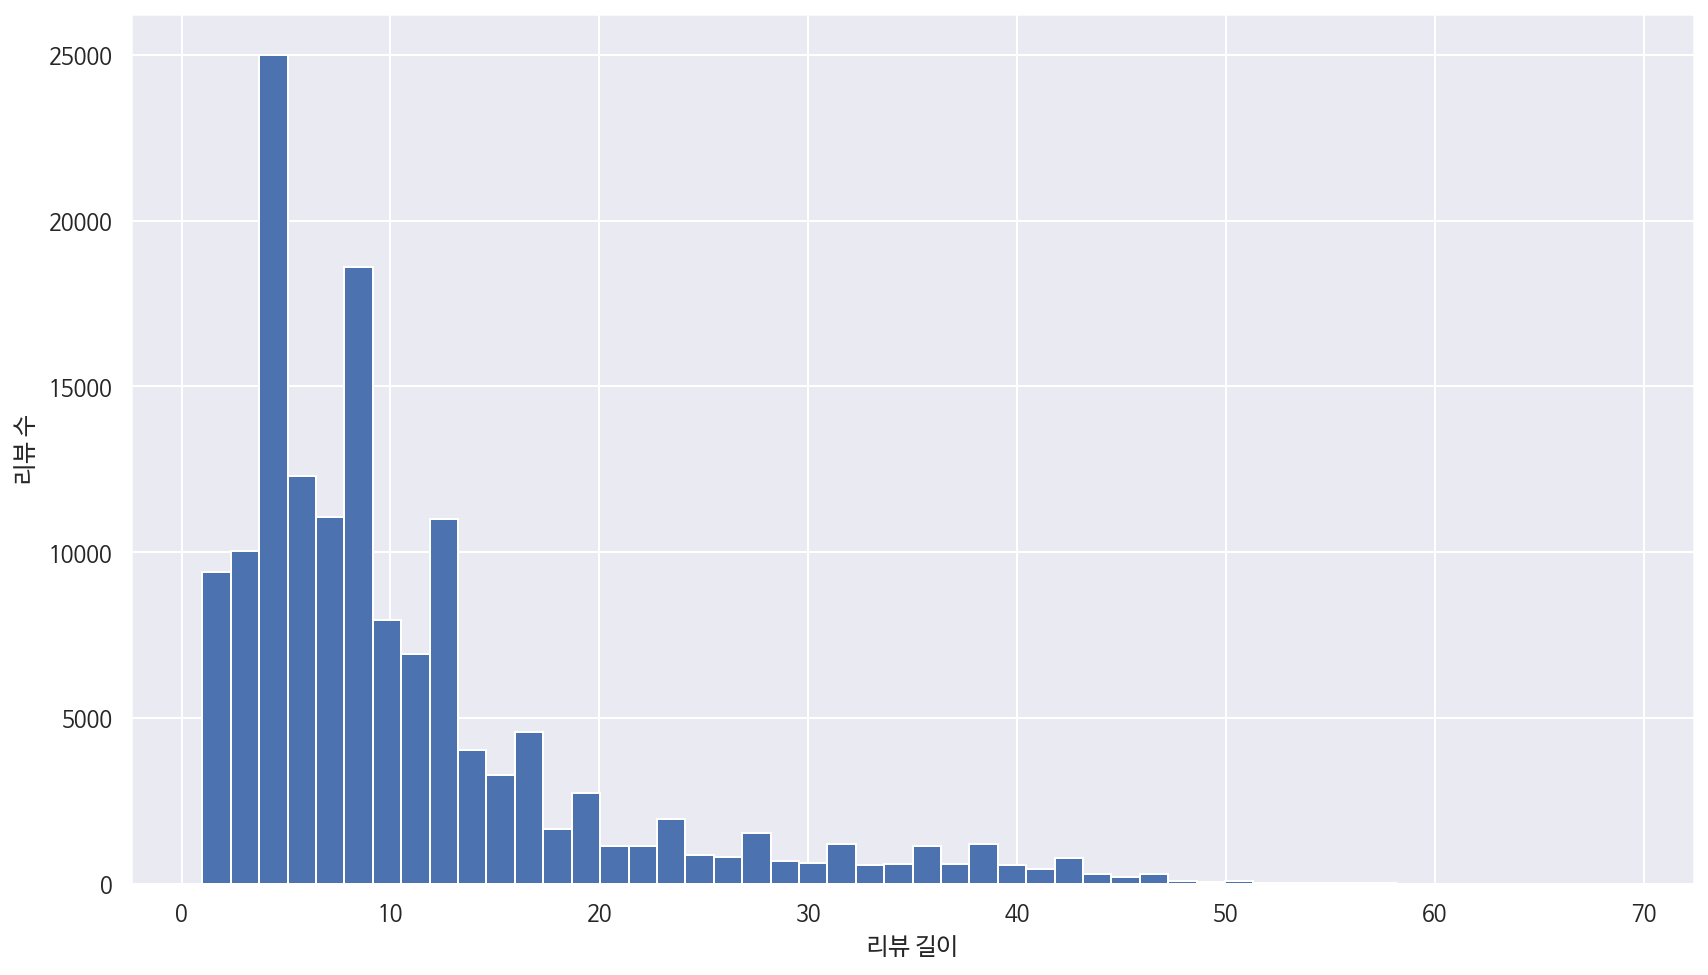

time: 1.66 s (started: 2021-02-14 07:57:39 +00:00)


In [ ]:
print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('리뷰 길이')
plt.ylabel('리뷰 수')
plt.show()

In [ ]:
max_len = 30
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

time: 937 ms (started: 2021-02-14 07:58:38 +00:00)


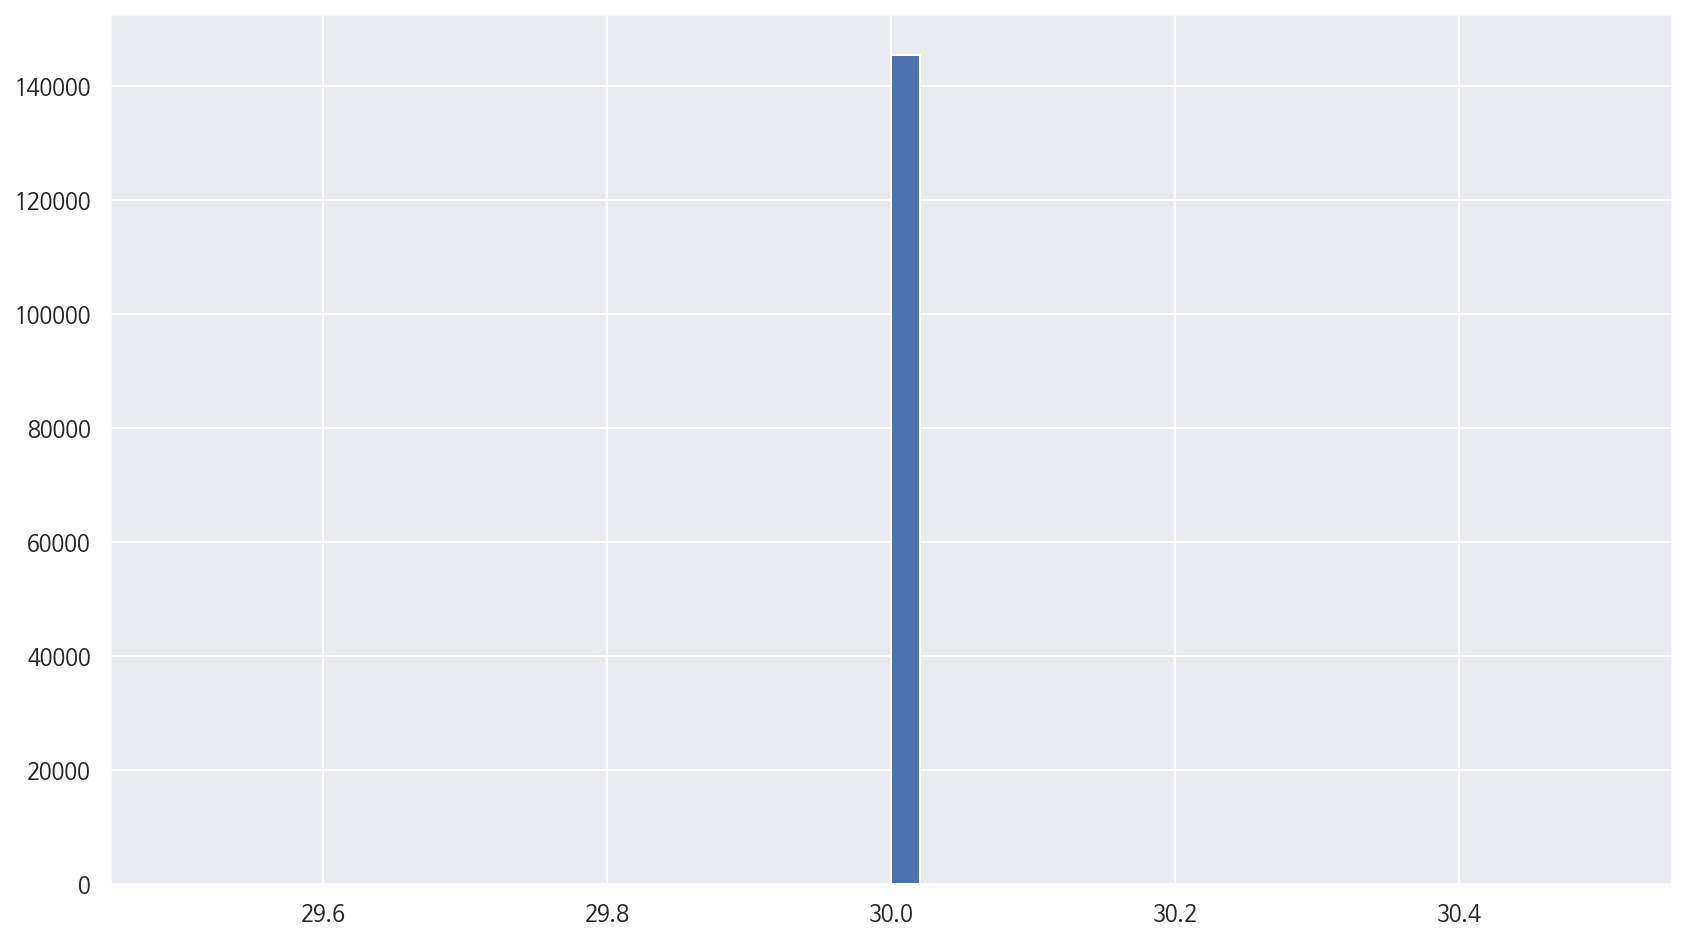

time: 1.27 s (started: 2021-02-14 07:58:53 +00:00)


In [ ]:
# 패딩 작업이 잘 되었나 확인
plt.hist([len(s) for s in X_train], bins=50)
plt.show()

### 장단기 메모리(Long Short-Term Memory)

- LSTM에 대한 '그나마 쉬운' 설명: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
  - 여기에서는 위 글의 내용에 기반해서 LSTM의 원리에 대해서만 간단하게 다룸. 
  - 위 글의 우리말 번역: https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr
- LSTM은 순환 신경망(RNN: Recurrent Neural Network)의 일종임. 


#### n-gram, RNN, LSTM

**n-gram**

- "I love you"란 문장이 주어졌을 때 이 문장의 likelihood를 계산하는 방법
\begin{equation}
Pr(\text{"I love you"}) = Pr(\text{"you"|"love","I"})\times Pr(\text{"love"|"I"}) \times Pr(\text{"I"})
\end{equation}

- 즉 "I love you"란 문장을 볼 확률은 "I love"가 이미 있을 때 "you"가 올 확률, "I"가 이미 있을 때 "love"가 올 확률, "I"가 문장 처음에 쓰일 확률을 곱해서 구하게 됨. 
- ngram에서 n=2로 두어 "I love", "love you"를 학습시킬 수 있음. n=3인 경우 "I love you"
- 그러나 n이 커질수록 단어들의 조합 수가 커지면서 차원의 저주가 나타날 수 있음. 
- 또한 "In Korea, most of people speak ____"의 예로 보면 ___에는 'Korean'이 들어가는 것이 가장 적절하나 n이 작을 경우 앞 부분의 "In Korea"를 포함하지 못 해서 "Korean", "Japanese", "English" 등 외국어 이름들이 모두 들어가도 무방한 상황이 됨 $\rightarrow$ ngram의 경우 장기 메모리가 취약함. 즉 앞에서 봤던 "In Korea"를 까먹은 상황임. 
- 또한 훈련시킨 ngram 이외에 새로운 ngram이 나올 경우 확률을 0으로 부여하는 상황도 발생할 수 있음. 

**RNN**

- RNN은 위의 ngram과 달리 스스로를 반복하면서 이전 단계에서 얻은 정보가 지속되도록 함. 
  - 영화를 보는 예를 든다면 ngram은 주어진 시간 간격(예를 들어 5분)안의 인물, 줄거리를 기억해서 영화를 이해하는 방식이라면 RNN은 영화 처음부터 일어난 사건, 인물들과의 연관성을 기억하고 있음. 
- [아래 그림](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)에서 A는 RNN의 한 덩어리이며 인풋(x)으로 아웃풋(h)을 출력할 때마다 이전 정보들을 건네받고 있다. 

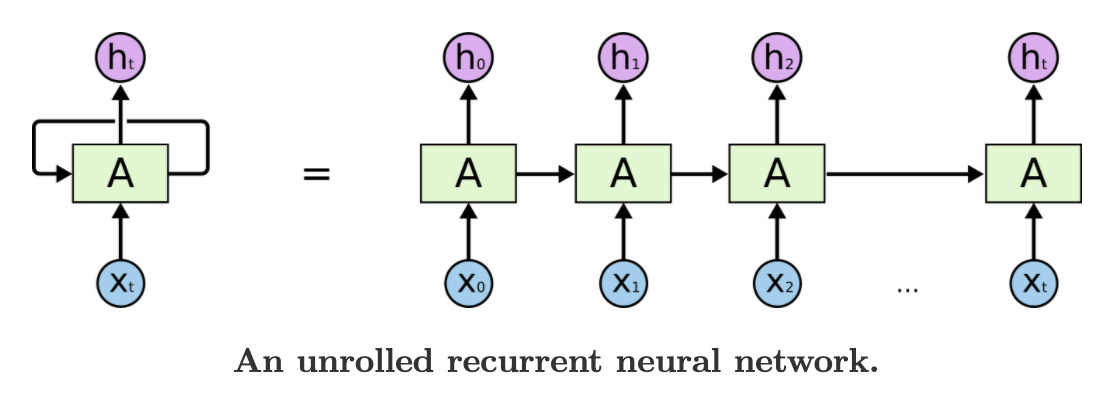

- 만약 "the clouds are in the ___ "의  마지막 ___ 에 단어 하나를 집어 넣으라면 높은 확률로 sky를 선택할 것임. 즉 필요한 정보를 얻기 위한 시간 격차가 크지 않다면 선택이 맞을 확률도 높음.
- 하지만 "I grew up in France... I speak fluent ____ "의 예를 생각해 보자:
  - ___ 에 French가 들어갈 수도 있지만, 만약에 문장의 의미가 "나는 프랑스에 오래 살았지만 다른 언어도 한다"라면 ___에는 다른 외국어 이름이 들어갈 수도 있다. 
  - 문장의 길이가 길수록 이런 문제는 더 심각해짐.
- 앞에서 본 long-term depedency의 문제인데 RNN은 **이론적으로** 이 문제를 해결할 수 있다고 함 $\rightarrow$ 실제로는 쉽지 않음 $\rightarrow$ LSTM



**LTSM**

- [Hochreiter & Schmidhuber (1997)](http://www.bioinf.jku.at/publications/older/2604.pdf)
- LSTM은 RNN의 한 종류로 long-term dependenecy 문제를 잘 해결한다고 알려져 있으며 널리 쓰이고 있음. 
- LSTM은 RNN의 구조와 유사하나 매 단계마다 'gate'를 두어서 이전 단계의 정보를 얼마만큼 다음 단계로 넘길 것인지 결정함. 



### LSTM 적용

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

time: 4.58 ms (started: 2021-02-14 07:59:23 +00:00)


In [ ]:
model = Sequential()

# 임베딩 벡터 크기 = 100
model.add(Embedding(vocab_size, 100))

# LSTM 사용
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

time: 967 ms (started: 2021-02-14 07:59:24 +00:00)


In [ ]:
# 검증 데이터 손실(val_loss)이 증가 -> 과적합 가능성
# 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping) 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

# 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델 저장
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

time: 1.97 ms (started: 2021-02-14 07:59:29 +00:00)


In [ ]:
# 에포크는 총 10회 수행
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# 훈련 데이터 중 20%를 검증 데이터로 사용하며 정확도 확인
history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/10
1939/1939 [==============================] - 173s 86ms/step - loss: 0.4376 - acc: 0.7927 - val_loss: 0.3517 - val_acc: 0.8459

Epoch 00001: val_acc improved from -inf to 0.84592, saving model to best_model.h5
Epoch 2/10
1939/1939 [==============================] - 164s 84ms/step - loss: 0.3269 - acc: 0.8568 - val_loss: 0.3382 - val_acc: 0.8540

Epoch 00002: val_acc improved from 0.84592 to 0.85400, saving model to best_model.h5
Epoch 3/10
1939/1939 [==============================] - 164s 84ms/step - loss: 0.3024 - acc: 0.8712 - val_loss: 0.3376 - val_acc: 0.8548

Epoch 00003: val_acc improved from 0.85400 to 0.85482, saving model to best_model.h5
Epoch 4/10
1939/1939 [==============================] - 162s 84ms/step - loss: 0.2824 - acc: 0.8822 - val_loss: 0.3260 - val_acc: 0.8601

Epoch 00004: val_acc improved from 0.85482 to 0.86009, saving model to best_model.h5
Epoch 5/10
1939/1939 [==============================] - 164s 84ms/step - loss: 0.2657 - acc: 0.8897 - val_loss:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1941600   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,058,977
Trainable params: 2,058,977
Non-trainable params: 0
_________________________________________________________________
time: 9.25 ms (started: 2021-02-14 08:29:43 +00:00)


In [ ]:
loaded_model = load_model('best_model.h5')
test_accuracy = loaded_model.evaluate(X_test, y_test)[1]

print(f"테스트 정확도: {100*test_accuracy:.3f}%")

1532/1532 [==============================] - 21s 14ms/step - loss: 0.3331 - acc: 0.8546
테스트 정확도: 85.464%
time: 22.4 s (started: 2021-02-14 08:36:49 +00:00)


In [ ]:
#모델을 저장해둘수도 있음.

filepath = '/content/drive/MyDrive/Colab Notebooks/Teaching/2021YonseiNaverCloud_NLP/data/'
model.save(filepath + 'best_model.h5')

# 모델 불러오기
#from keras.models import load_model
#model = load_model(filepath+'best_model.h5')

time: 2.92 s (started: 2021-02-14 08:33:25 +00:00)


In [ ]:
def sentiment_predictor(sentence):
  new_sentence = okt.morphs(sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  padded = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(padded)) # 예측
  if(score > 0.5):
    print(f"{100*score:.2f}% 확률로 긍정 리뷰입니다.")
  else:
    print(f"{(1-score)*100:.2f}% 확률로 부정 리뷰입니다.")
    #print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

time: 10.4 ms (started: 2021-02-14 08:35:46 +00:00)


#### 리뷰 예측

In [ ]:
# 영화 그린북의 리뷰 중 하나
sentiment_predictor("가슴찡하게 울리는 뭔가가 다가옵니다")

99.10% 확률로 긍정 리뷰입니다.
time: 439 ms (started: 2021-02-14 08:35:48 +00:00)


In [ ]:
# 영화 원더우먼 1984의 리뷰 중 하나 
sentiment_predictor("역시 원더우먼 영화는 주연배우 갤가돗과 크리스파인이 다 살리네.. 감독은 확실히 영화 못 찍음.... 예전 샤를리즈 테론 영화 몬스터만해도 배우가 다 살림... 원더우먼 1도 악당 허술하고 매력없고 스토리도 전개가 뒤로 갈수록 허술하더니 크리스파인의 명대사로 살렸는데.. 이번 2도 에휴... 역시나 악역 허술 전개도 뒤로 갈수록 허술..결말은 1탄보다 더 허술.. 난 중간에 영화 캣츠 보는 줄 ㅋㅋㅋㅋ웃겨 죽는 줄 알았다.. 그나마 크리스파인과 갤가돗의 사랑내용과 원더우먼이 전하는 세상의 아름다움과 진실 이런 내용이 좀 감동적이엇음 슬펐고 .. 한스 짐머 음악도 이번엔 딱히 임팩트 있음을 못 느낌.. 액션도 완전 실망..")

96.64% 확률로 부정 리뷰입니다.
time: 83.7 ms (started: 2021-02-14 08:35:50 +00:00)


In [ ]:
# 일부러 애매한 표현을 쓴 경우
sentiment_predictor("아 이건 재미있는 것도 아니고, 그렇다고 돈이 아깝지는 않고, 뭐라고 해야 하나")

51.24% 확률로 긍정 리뷰입니다.
time: 56.7 ms (started: 2021-02-14 08:35:51 +00:00)


In [ ]:
# 예시
sentiment_predictor("와~재미있다가 아니라...천천히 잔잔하게 스며드는 흐름이 좋았어요. 보여주기 위한 삶이 아닌 내 삶을 살아가는 과정을 잘 풀어낸듯한")

97.98% 확률로 긍정 리뷰입니다.
time: 58.8 ms (started: 2021-02-14 08:35:54 +00:00)
